# Oscillating Circuit Component Analysis
Author: Jan Hoegen \
Date: 2023-12-14

Goal: Find the actual component values for the coil and capacitor in the bandpass filter in the figure below.

The following steps are required:

1. Compare the measured response voltage $u_a$ with the predicted response voltage under nominal component values.
2. Determine their root mean square error (rmse).
3. Change the predicted response voltages for different value pairs of $L$ and $C$.
4. Minimize the rmse function to find the actual component values.

![Circuit Diagramm](circuit.png)

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sci
import math
import pandas as pd

In [10]:
COIL=9e-3
CAPACITOR=1000e-6
RESISTOR=20
INPUT_VOLTAGE = 2

STEPS = 40
COIL_LOWER = 7e-3
COIL_UPPER = 12e-3
CAPACITOR_LOWER = 9 * 100e-6
CAPACITOR_UPPER = 16 * 100e-6

plt.rcParams['axes.grid'] = True

with np.load("messwerte.npz") as file:
    time = file["t_mess"]
    measured = file["u_a_mess"]

# Analysis
## Plot Expected and Measured Data

In [6]:
def predict_voltage(coil: float, capacitor: float) -> list[float]:
    """
    Create a LTI System with a transfer function dependent on the resistors and return the output voltage of that system.

    Input: the values for the coil and capacitor in H and F.
    Output: A 1D list of the output voltage at time steps specified by the measured data points. (See get_measured_data)
    """
    numerator=[1/(RESISTOR*capacitor), 0]
    denominator=[1, 1/(RESISTOR*capacitor), 1/(coil*capacitor)]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    # calculate the output voltage at time points from the measured data.
    return INPUT_VOLTAGE * sci.signal.step(transfer_function, T=time)[1]

array([<Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>],
      dtype=object)

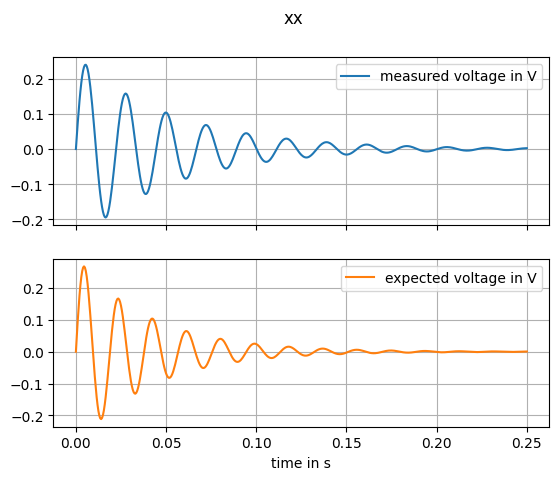

In [8]:
with np.load("messwerte.npz") as file:
    task1 = pd.DataFrame({
        "time in s": time,
        "measured voltage in V" : measured,
        "expected voltage in V" : predict_voltage(COIL, CAPACITOR),
    })
task1 = task1.set_index("time in s")

task1.plot(subplots=True, title="Respone Voltage $U_a$ of the Bandfilter")

## Calculate Root Mean Square Error

In [63]:
def root_mean_square_error(predicted_voltage: list[float]) -> float: 
    """
    Calculate the root mean square error of the input list compared to the measured data of u_a.

    Input: Input Voltage as a 1D list.
    Output: Root mean square error of the input voltage comparing input to measured data. Rounded to 2 decimal places.
    """
    rsme = np.sqrt(1/len(predicted_voltage) * np.sum(np.square(np.subtract(predicted_voltage, voltage_out["measured voltage"]))))
    return np.round(rsme, 2)

rsme_nominal = root_mean_square_error(voltage_out["predicted voltage"])
print(f"RSME with nominal values: {rsme_nominal*10**3} mV")

RSME with nominal values: 60.0 mV


# Find true Capacitor and Coil Values

## Create RSME Grid for Different Values

In [64]:

def create_rsme_grid(coil_list: list[float], capacitor_list : list[float]) -> np.ndarray:
    """
    Calculate the RSME for all pairs of capacitor and coil values. The voltage is calculated with the resistor values and compared to the measured data.

    Input: 1D list of capacitor values in F, 1d list of coil values in H.
    Output: A 2D matrix assigning a root mean square error for all positions x,y. x-axis is the coil values, y-axis is the capacitor values. 
    """
    # reserve array space
    rsme = np.zeros((len(coil_list), len(capacitor_list))) 

    # calculate rsme for all input pairs
    for i in range(len(coil_list)):
        for j in range(len(capacitor_list)):
            voltage = predict_voltage(coil_list[i], capacitor_list[j])
            rsme[i][j] = root_mean_square_error(voltage)

    return rsme

coil_range = np.linspace(COIL_LOWER, COIL_UPPER, STEPS)
capacitor_range = np.linspace(CAPACITOR_LOWER, CAPACITOR_UPPER, STEPS)

rsme_grid = create_rsme_grid(coil_range.tolist(), capacitor_range.tolist())

## Plot RSME Contour and Surface

C:\Users\janho\AppData\Local\Temp\ipykernel_5568\2479704382.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(coil_range*10**3, capacitor_range*10**3, rsme_grid*10**3, label="RSME")


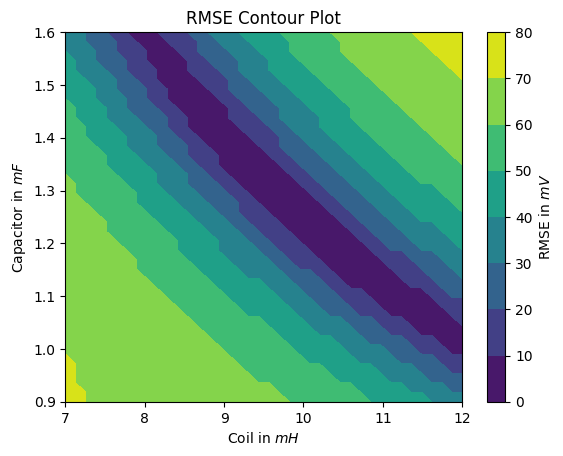

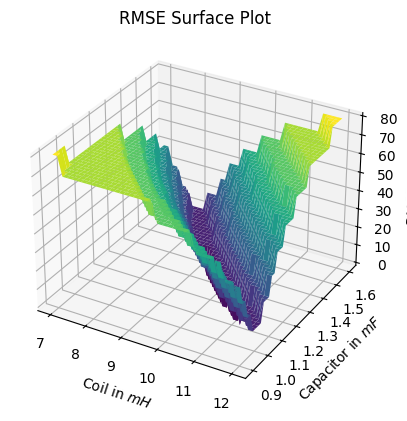

In [65]:
def plot_rsme():
    """
    Plot RSME as 3D colormap and change the magnitude by 10**-3.
    """
    plt.contourf(coil_range*10**3, capacitor_range*10**3, rsme_grid*10**3, label="RSME")

    plt.title('RMSE Contour Plot')
    plt.xlabel('Coil in $mH$')
    plt.ylabel('Capacitor in $mF$')
    plt.colorbar(label='RMSE in $mV$')

plot_rsme()

def plot_rsme_3d():
    """
    Plot RSME as 3D height map and change the magnitude by 10**-3.
    """
    x,y = np.meshgrid(coil_range, capacitor_range)
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(x*10**3, y*10**3, rsme_grid*10**3, cmap='viridis')
    plt.title('RMSE Surface Plot')
    ax.set_xlabel('Coil in $mH$')
    ax.set_ylabel('Capacitor in $mF$')
    ax.set_zlabel('RMSE in mV')

plot_rsme_3d()

## Minimize rsme with variable parameters

In [66]:
def rsme_single_input(params):
    # redefine rms function to work with a single input variable.
    # params is a 1d array. first element is the coil, second element is the capacitor.

    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*params[1]), 0]
    denominator=[1, 1/(RESISTOR*params[1]), 1/(params[0]*params[1])]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    voltage =  INPUT_VOLTAGE*sci.signal.step(transfer_function, T=voltage_out["time"])[1]

    return root_mean_square_error(voltage)

def rsme_min():
    INITIAL_GUESS = [COIL, CAPACITOR]
    BOUNDS = [(COIL_LOWER, COIL_UPPER),(CAPACITOR_LOWER, CAPACITOR_UPPER)]

    # ! rsme function retuns discrete values. So minimize can't calculate a gradient. 
    return sci.optimize.dual_annealing(rsme_single_input, BOUNDS, x0=INITIAL_GUESS)
    # return sci.optimize.minimize(rsme_singel_input, initial_guess, tol = 1e-15)

rsme = rsme_min()

best_coil, best_capacitor = np.round(rsme.x, 5)
all_best_rsme = np.round(rsme.fun,5)

print(f"True Coil:\t{best_coil*10**3} mH ")
print(f"True Capacitor:\t{best_capacitor*10**3} mF")
print(f"Minimum RMSE:\t{all_best_rsme*10**3} mV")

True Coil:	10.25 mH 
True Capacitor:	1.22 mF
Minimum RMSE:	0.0 mV


# Find all possible parameters so that $RSME$ = 0
Use Thom's oscillation formula to find all pairs of coil and capacitance.

C:\Users\janho\AppData\Local\Temp\ipykernel_5568\3945794048.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(coil_range*10**3, capacitor_range*10**3, rsme_grid*10**3, label="RSME")


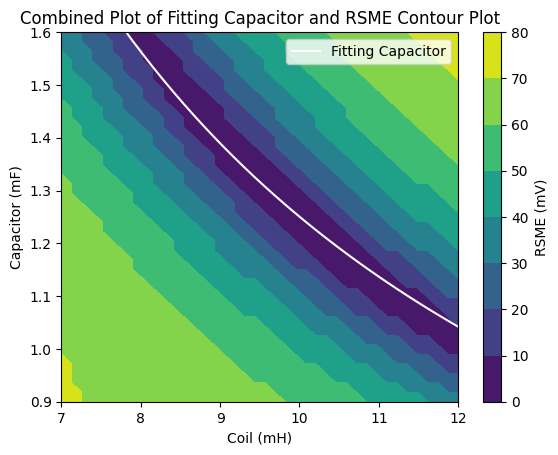

In [67]:
FREQUENCY = 1 / (2 * math.pi * math.sqrt( best_coil * best_capacitor ))

def fits_capacitor(coil): 
    return 1 / ( FREQUENCY * 2 * math.pi ) ** 2 * 1/coil

fitting_cap = fits_capacitor(coil_range)



plt.plot(coil_range*10**3, fitting_cap*10**3, label="Fitting Capacitor", color="white")
plt.contourf(coil_range*10**3, capacitor_range*10**3, rsme_grid*10**3, label="RSME")
plt.ylim(top=1.6)
plt.xlabel('Coil (mH)')
plt.ylabel('Capacitor (mF)')
plt.colorbar(label='RSME (mV)')
plt.title('Combined Plot of Fitting Capacitor and RSME Contour Plot')
plt.legend()

# Closing Notes

The RSME function is minimal when the calculted voltage is (almost) identical to the measured voltage. The coordinates of the global minimum are the true hardware parameters of C and L.

This is true of for all pairs of C and L that produce the same transferfunction  